# SQL for data analysis - sql + pandas + duckdb
Following along this tutorial, using duckdb as olap database engine:
https://hakibenita.com/sql-for-data-analysis#pandas-and-sql-better-together

In [3]:
import psycopg2
import pandas as pd
import duckdb as ddb
conn = ddb.connect() # Start ddb connection

## Create table

In [4]:

ddb.sql("CREATE SEQUENCE seq_userid START 1;") 
ddb.sql("""
CREATE TABLE users (
id INT PRIMARY KEY default nextval('seq_userid'),
username TEXT NOT NULL,
activated BOOLEAN NOT NULL
);""")

ddb.sql("""
INSERT INTO users (
    username,
    activated
)
SELECT
    md5(random()::text)::text AS username,
    random() > 0.9 AS activated
FROM
    generate_series(1, 1000000);
""")

Export database to parquet + sql files

In [5]:
ddb.sql("EXPORT DATABASE 'data' (FORMAT PARQUET);")
print("Created database and saved it to ./data folder")

Created database and saved it to ./data folder


## Other
**Integration with s3** using duckdb extensions (source: https://motherduck.com/blog/duckdb-tutorial-for-beginners/)

```sql
-- Install extensions
INSTALL httpfs;
LOAD httpfs;
-- Minimum configuration for loading S3 dataset if the bucket is public
SET s3_region='us-east-1';

## Basics

Import database from parquet + sql files generated by duckdb EXPORT statement

In [ ]:
ddb.sql("IMPORT DATABASE 'data';")
print("Importing database from ./data folder")

### Parse results as df and aggregate

In [7]:
df = ddb.sql("SELECT * FROM users").df()

result = df.groupby(by='activated').count()
print(result)

               id  username
activated                  
False      900355    900355
True        99645     99645


### Common table expressions

**Common clauses of an SQL query:**

```sql
SELECT <expressions>
FROM <tables>
JOIN <to other table> ON <join condition>
WHERE <predicates>
GROUP BY <expressions>
HAVING <predicate>
ORDER BY <expressions>
LIMIT <number of rows>
```

In [9]:
ddb.sql("""
WITH emails AS (
    SELECT 'ME@hakibenita.com' AS email
)
SELECT * FROM emails;
""").df()

,email
0,ME@hakibenita.com


In [12]:
ddb.sql("""
WITH emails AS (
    SELECT 'ME@hakibenita.com' AS email
),
normalized_emails AS (
    SELECT lower(email) AS email FROM emails
)
SELECT * FROM normalized_emails;
""").df()

,email
0,me@hakibenita.com


### Generating data

#### UNION ALL
Using UNION ALL you can combine, or concatenate, the results of multiple queries. Can be tedious for generating data.

In [14]:
ddb.sql("""
WITH dt AS (
    SELECT 1 AS id, 'haki' AS name
    UNION ALL
    SELECT 2, 'benita'
)
SELECT * FROM dt;
""").df()

,id,name
0,1,haki
1,2,benita


#### VALUES LIST
Using the VALUES keyword you can provide a list of rows, and then define names and types using a "table alias list" t(..). The t can be any name. Using a VALUES list is very useful when you need to generate small sets of data, or as the documentation calls it, "constants table".

In [15]:
ddb.sql("""
WITH dt AS (
    SELECT * FROM (
        VALUES
            (1, 'haki'),
            (2, 'benita')
    ) AS t(id, name)
)
SELECT * from dt;
""").df()

,id,name
0,1,haki
1,2,benita


#### UNNEST
Generate small sets of one dimensional data of the same datatype by unnesting a PostgreSQL array. I think by one-dimensional this means a single column.

In [18]:
ddb.sql("""
WITH dt AS (
    SELECT unnest(array[1, 2]) AS n
)
SELECT * FROM dt;
""").df()

,n
0,1
1,2


#### GENERATE_SERIES
To generate large amounts of data, PostgreSQL provides a table function called `generate_series`. The function generate_series accepts three arguments: start, stop and step. If we don't specify a step, the default 1 is used. We can provide a different step to generate a different series.

In [22]:
print("Step=1")
display(ddb.sql("""
WITH dt AS (
    SELECT * FROM generate_series(0, 5) AS t(n)
)
SELECT * FROM dt;
""").df())

print("Step=2")
display(ddb.sql("""
WITH dt AS (
    SELECT * FROM generate_series(
        0,  -- start
        10, -- stop
        2   -- step
    ) AS t(n)
)
SELECT * FROM dt;
""").df())

Step=1


,n
0,0
1,1
2,2
3,3
4,4
5,5


Step=2


,n
0,0
1,2
2,4
3,6
4,8
5,10


It can be used for other types as well, for example sequence of dates (modified code using https://duckdb.org/docs/sql/functions/timestamp.html as reference, this works better than code provided by tutorial)

In [ ]:
print("Sequence of dates")
ddb.sql(
"""
WITH daterange AS (
    SELECT *
    FROM generate_series(
        TIMESTAMP '2021-01-01 00:00:00 UTC', -- start
        TIMESTAMP '2021-01-01 00:00:00 UTC' + INTERVAL 1 DAY, -- stop
        interval '1 hour'   -- step
    ) AS t(hh)
) SELECT * FROM daterange;
"""
).df()

#### GENERATE_SERIES with row numbers
Could use WITH ORDINALITY, so the results now include another column with the row number.
NOT IMPLEMENTED on duckDB, not sure how to replace in a simple way.

In [29]:
# NO FUNCIONA CON DUCKDB
print("Sequence of dates")
ddb.sql(
"""
WITH daterange AS (
    SELECT *
    FROM generate_series(
        TIMESTAMP '2021-01-01 00:00:00 UTC', -- start
        TIMESTAMP '2021-01-01 00:00:00 UTC' + INTERVAL 1 DAY, -- stop
        interval '1 hour'   -- step
    ) WITH ORDINALITY AS t(hh, n)
) SELECT * FROM daterange;
"""
).df()

Sequence of dates


NotImplementedException: Not implemented Error: WITH ORDINALITY not implemented

### Random
`random` function returns float64 between 0 and 1.

In [41]:
print(f"Random float between 0 and 1: {ddb.sql("SELECT random();").df().iloc[0,0]}")
print(f"Random float between 0 and 100: {ddb.sql("SELECT random() * 100;").df().iloc[0,0]}")
print(f"Random integer between 1 and 100: {ddb.sql("SELECT ceil(random() * 100);").df().iloc[0,0]}")
print(f"Random integer between 11 and 100: {ddb.sql("SELECT 10 + ceil(random() * 90);").df().iloc[0,0]}")

Random float between 0 and 1: 0.5584747835528105
Random float between 0 and 100: 15.709676733240485
Random integer between 1 and 100: 68.0
Random integer between 11 and 100: 97.0


It's a common mistake to use `round` instead of `ceil` or `floor` to generate a range of integers. Using round may produce inconsistent distribution. Consider the following query to generate random integers in the range 0 - 4 using round instead ceil:

Notice how the values 0 and 3 are coming up less than 1 and 2. Using round, random values less than 0.5 will be rounded down to 0, and random numbers greater than 2.5 will be rounded up to 3, while for example, random values between 0.5 and 1.5 will be rounded to 1. This makes the edges less likely to come up.

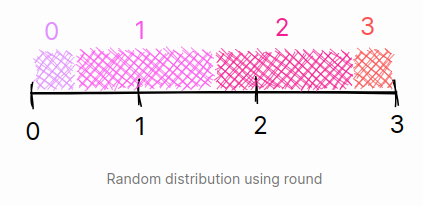

In [47]:
print("Rounding with **round**")
display(ddb.sql("""
SELECT
    round(random() * 3) AS n,
    count(*)
FROM
    generate_series(0, 1000)
GROUP BY
    1;     
""").df())

print("Rounding with **ceil**")
display(ddb.sql("""
SELECT
    ceil(random() * 3) AS n,
    count(*)
FROM
    generate_series(0, 1000)
GROUP BY
    1;     
""").df())

print("Rounding with **floor**")
display(ddb.sql("""
SELECT
    floor(random() * 3) AS n,
    count(*)
FROM
    generate_series(0, 1000)
GROUP BY
    1;     
""").df())

Rounding with **round**


,n,count_star()
0,0.0,155
1,3.0,177
2,2.0,321
3,1.0,348


Rounding with **ceil**


,n,count_star()
0,1.0,349
1,3.0,330
2,2.0,322


Rounding with **floor**


,n,count_star()
0,0.0,334
1,2.0,332
2,1.0,335
